In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import euclidean
from scipy import stats

In [10]:
#set crs for Denmark
epsg_dk = 25832 

In [11]:
#load station data
org_stations = gpd.read_file('data/raw/original_stations.geojson')
org_stations = org_stations.to_crs(epsg_dk)

#remove duplicate stations (e.g., Vanløse, Hovedbanegården)
org_stations = org_stations.drop_duplicates(subset=['name'])

#only keep relevant columns
stations = org_stations[['name', 'geometry']].copy()

#load study area boundary
area = gpd.read_file('data/raw/storkøbenhavn.geojson')
area = area.to_crs(epsg=epsg_dk)

In [12]:
print(f'we have with {len(stations)} stations to work with.')

we have with 129 stations to work with.


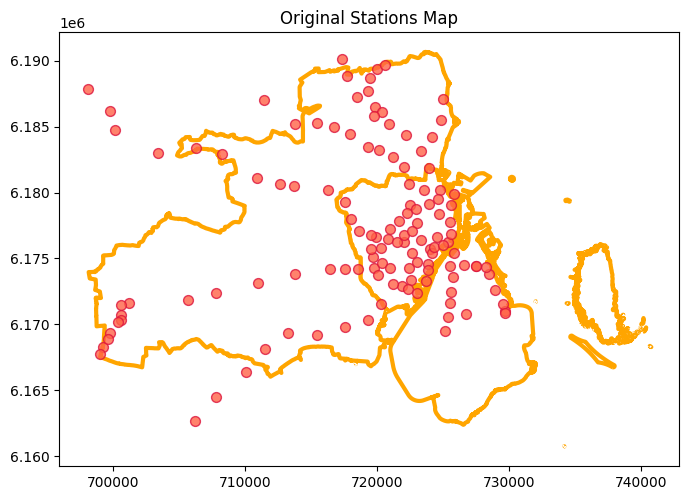

None


In [ ]:
def plot_stations_map(stations, area):
     '''Plot stations on the study area boundary'''
     fig, ax = plt.subplots(figsize=(8, 6))
     area.plot(ax=ax,color='white', edgecolor='orange', linewidth=3)
     stations.plot(ax=ax,marker='.', color='tomato', edgecolor='crimson', markersize=200, alpha =0.8)
     ax.set_title('Original Stations Map')
     plt.savefig('figures/org_stations_map.png')
     plt.show()

print(plot_stations_map(stations, area))

In [ ]:
#stations located outside the study area boundary to be deleted
st_to_delete = ['Lyngby Lokal', 'Værløse', 'Holte', 'Hareskov', 'Veksø','Stenløse', 'Egedal', 'Ølstykke', 'Hundige', 'Greve', 'Karlslunde', 
               'Hedehusene', 'Hedehusgård', 'Sølund', 'Stenager Trinbræt', 'Brandhøj', 'Flintebjerg Trinbræt', 'Fem Ege', 'Rubjerg', 
               'Hedenlands Veteranbane', 'Plantagen Trinbræt', 'Lufthavnen (Metro)', 'Tårnby']

#filter out the stations to be deleted
stations = stations[~stations['name'].isin(st_to_delete)]

print(f'Deleted {len(st_to_delete)} stations. This gives us {len(stations)} stations to work with.')

#export cleaned dataset for further analysis
stations.to_file('data/processed/stations.geojson', driver='GeoJSON')

Deleted 23 stations. This gives us 107 stations to work with.


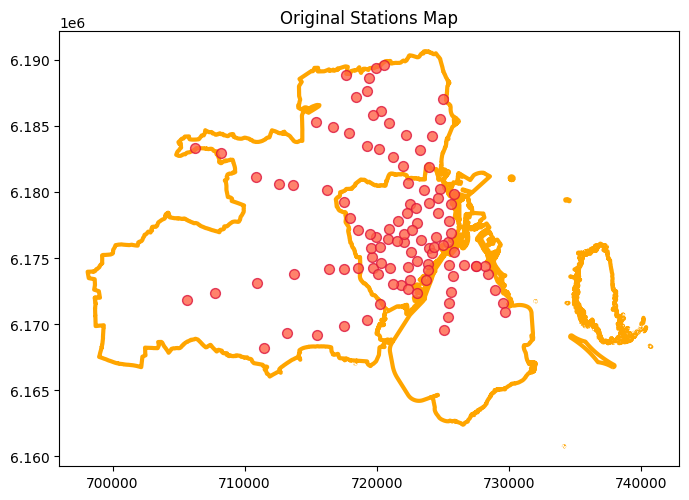

In [ ]:
def plot_clean_stations_map(stations, area):
     '''Plot reamaining stations on the study area boundary'''
     fig, ax = plt.subplots(figsize=(8, 6))
     area.plot(ax=ax,color='white', edgecolor='orange', linewidth=3)
     stations.plot(ax=ax,marker='.', color='tomato', edgecolor='crimson', markersize=200, alpha =0.8)
     ax.set_title('Stations Map')
     plt.savefig('figures/stations_map.png')
     plt.show()

plot_stations_map(stations,area)

In [17]:
#load kebap places data
org_kebap_places = gpd.read_file('data/raw/original_kebap_places.geojson')

#keep only relevant columns
kebap_places = org_kebap_places[['name', 'geometry']].copy()

kebap_places = kebap_places.to_crs(epsg=epsg_dk)

print(f'we have with {len(kebap_places)} kebap places.')

we have with 117 kebap places.


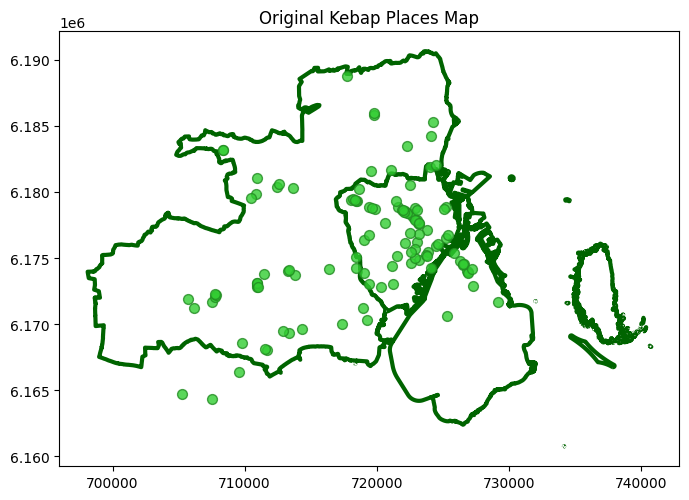

In [ ]:
def plot_kebap_places(kebap_places, area):
     '''Plot kebap restaurant locations on the study area boundary'''

     fig, ax = plt.subplots(figsize=(8, 6))
     area.plot(ax=ax,color='white', edgecolor='darkgreen', linewidth=3)
     kebap_places.plot(ax=ax,marker='.', color='limegreen', edgecolor='forestgreen', markersize=200, alpha =0.8)
     ax.set_title('Original Kebap Places Map')
     plt.savefig('figures/org_kebap_places_map.png')
     plt.show()

plot_kebap_places(kebap_places, area)

In [ ]:
#check for duplicate names to identify potential chain restaurants
#before removing the kebap places outside the area boundary make sure they are not part of a chain restaurant
duplicates = kebap_places['name'].value_counts()
branched = duplicates[duplicates > 1]

print(branched)

#Konya Kebab located in Ishøj should be removed 
#get all Konya Kebab locations to get their index
print(kebap_places[kebap_places['name'] == 'Konya Kebab'])

#drop the one at index 24
kebap_places = kebap_places.drop(index=24)

#other places to be deleted
places_to_delete= ["Roll N’ Eat", "Kebabi", "Virum Kebab house"]
kebap_places = kebap_places[~kebap_places['name'].isin(places_to_delete)]

print(f'We got {len(kebap_places)} kebap places left.')

#export cleaned dataset for further analysis
kebap_places.to_file('data/processed/kebap_places.geojson', driver='GeoJSON')

name
Killer Kebab    4
Konya Kebab     3
Kebabi          2
Kebabland       2
City Kebab      2
Name: count, dtype: int64
           name                        geometry
9   Konya Kebab  POINT (723148.674 6177659.672)
17  Konya Kebab  POINT (707776.283 6172090.852)
24  Konya Kebab   POINT (709576.53 6166343.062)
We got 112 kebap places left.


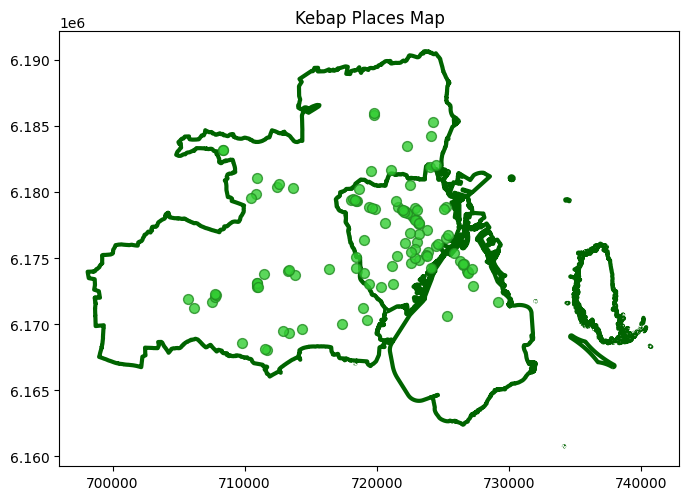

In [ ]:
def plot_kebap_places_clean(kebap_places, area):
     '''Plot the reamaining kebap restaurants on the study area boundary'''
     fig, ax = plt.subplots(figsize=(8, 6))
     area.plot(ax=ax,color='white', edgecolor='darkgreen', linewidth=3)
     kebap_places.plot(ax=ax,marker='.', color='limegreen', edgecolor='forestgreen', markersize=200, alpha =0.8)
     ax.set_title('Kebap Places Map')
     plt.savefig('figures/kebap_places_map.png')
     plt.show()

plot_kebap_places_clean(kebap_places, area)

In [21]:
#load google ratings data
google_ratings = pd.read_csv('data/results/kebap_with_ratings.csv')

#merge kebap places data with the corresponding google ratings
kebap_w_ratings = kebap_places.merge(
     google_ratings,
     left_on='name',
     right_on='osm_name',
     how='left'
)

#drop the one of the name columns
kebap_w_ratings.drop('osm_name', axis=1, inplace=True)

In [22]:
#extract the closest station for each kebap place
def closest_station(places, stations):
     '''
     Take each kebap places and calculates the closest station using the Euclidean distance.
     Save the results in a dataframe.
     '''

     result = []
     
     #iterate over each kebap place
     for idx_k, row_k in places.iterrows():
          distances = {} #store the distances
          
          #get coordinates of each kebap place
          loc_k= row_k.geometry.x, row_k.geometry.y

          #loop through all stations for each kebap place
          for idx_s, row_s in stations.iterrows():
               loc_s= row_s.geometry.x, row_s.geometry.y
               distance = euclidean(loc_k, loc_s) #calculate euclidean distance
               distances[row_s['name']] = distance 
          min_dist = min(distances.values()) #extract the minimum distance
          closest_st = min(distances, key=distances.get) #extract the station corresponding to the minimum distance

          #save results in a dictionary
          result.append({
          'kebap_place_name': row_k['name'],
          'closest_station': closest_st,
          'distance': min_dist
          })
     
     #convert results to a dataframe
     result_df = pd.DataFrame(result)

     return result_df

closest_stations = closest_station(kebap_places, stations)

In [23]:
closest_stations = closest_station(kebap_places, stations)

#merge the results with the dataset including kebap places and ratings 
df = closest_stations.merge(kebap_w_ratings, left_on='kebap_place_name', right_on = 'name')
df.drop(columns='name', inplace=True)

#check for isna, should have done in the beginning but oh well
print(df.isna().sum())

#drop the nan columns 
df = df.dropna(subset=['rating', 'distance', 'adjusted_rating'])

kebap_place_name    0
closest_station     0
distance            0
geometry            0
Unnamed: 0          0
rating              1
review_count        1
adjusted_rating     1
dtype: int64


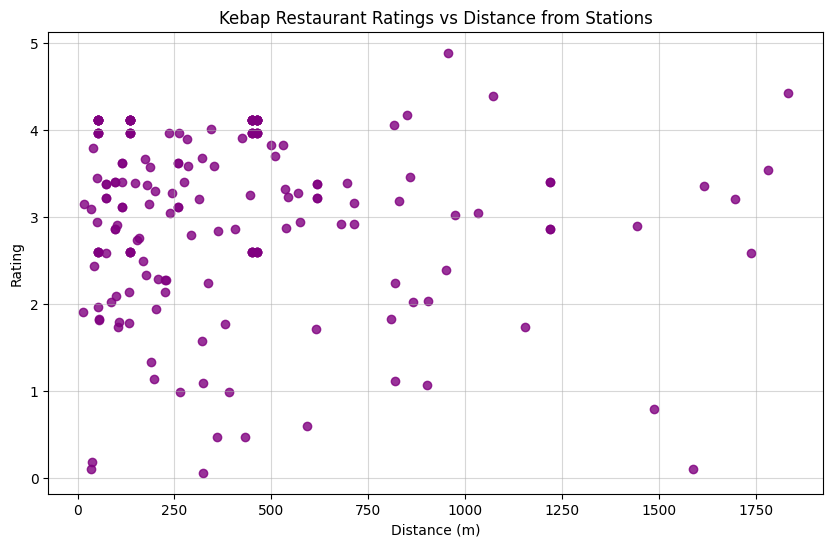

In [ ]:
def scatter_ratings_vs_distance(distance, ratings):
     ''''
     Scatter plot between kebap restaurant ratings and distance from nearest station.
     '''
     plt.figure(figsize=(10, 6))
     plt.scatter(distance, ratings, color='purple', alpha= 0.8)
     plt.xlabel('Distance (m)')
     plt.ylabel('Rating')
     plt.title('Kebap Restaurant Ratings vs Distance from Stations')
     plt.grid(alpha=0.5)
     plt.savefig('figures/ratings_distance_scatter.png')
     plt.show()

scatter_ratings_vs_distance(df['distance'], df['adjusted_rating'])

In [32]:
#statistical analysis
cor_s, p_val_s = stats.spearmanr(df['adjusted_rating'], df['distance'])
cor_p, p_val_p = stats.pearsonr(df['adjusted_rating'], df['distance'])

#correlation results
print("Correlation Analysis Results:")
print(f'Spearman correlation: {cor_s:.3f} (p={p_val_s:.4f})')
print(f'Pearson correlation:  {cor_p:.3f} (p={p_val_p:.4f})')

Correlation Analysis Results:
Spearman correlation: 0.002 (p=0.9797)
Pearson correlation:  -0.055 (p=0.4528)
